# Generate Art using one style image

## Summary

This project is created to complete the [Siraj Raval's video](https://www.youtube.com/watch?v=Oex0eWoU7AQ&list=PL2-dafEMk2A7YdKv4XfKpfbTH5z6rEEj3&index=15) challenge to generate an art using two style image.
I have used my own image as a content image to complete the challenge.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.io import imread,imshow
from skimage.transform import resize
from keras import backend as K
from PIL import Image

Using TensorFlow backend.


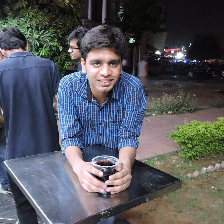

In [13]:
height = 224
width = 224

content_image_path = './sh.jpg'
content_image = Image.open(content_image_path)
content_image = content_image.resize((height, width))
content_image

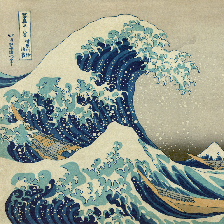

In [14]:
style_image_path1 = './wave.jpg'
style_image1 = Image.open(style_image_path1)
style_image1 = style_image1.resize((height, width))
style_image1

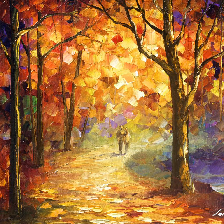

In [15]:
style_image_path2 = './forest.jpg'
style_image2 = Image.open(style_image_path2)
style_image2 = style_image2.resize((height, width))
style_image2

In [16]:
content_array = np.asarray(content_image, dtype='float32')
content_array = np.expand_dims(content_array, axis=0)
print(content_array.shape)

style_array1 = np.asarray(style_image1, dtype='float32')
style_array1 = np.expand_dims(style_array1, axis=0)
print(style_array1.shape)

style_array2 = np.asarray(style_image2, dtype='float32')
style_array2 = np.expand_dims(style_array2, axis=0)
print(style_array2.shape)

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


In [17]:
content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array = content_array[:, :, :, ::-1]

style_array1[:, :, :, 0] -= 103.939
style_array1[:, :, :, 1] -= 116.779
style_array1[:, :, :, 2] -= 123.68
style_array1 = style_array1[:, :, :, ::-1]

style_array2[:, :, :, 0] -= 103.939
style_array2[:, :, :, 1] -= 116.779
style_array2[:, :, :, 2] -= 123.68
style_array2 = style_array2[:, :, :, ::-1]

In [20]:
content_image = K.variable(content_array)
style_image1 = K.variable(style_array1)
style_image2 = K.variable(style_array2)
combination_image = K.placeholder((1, height, width, 3))

In [21]:
input_tensor = K.concatenate([content_image, style_image1, style_image2 ,combination_image],axis = 0)

In [22]:
from keras.applications import vgg16

model = vgg16.VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor)
print('model loaded')

model loaded


In [23]:
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers

{'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(4, 224, 224, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(4, 224, 224, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(4, 112, 112, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(4, 112, 112, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(4, 112, 112, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(4, 56, 56, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(4, 56, 56, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(4, 56, 56, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(4, 56, 56, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool/MaxPool:0' shape=(4, 28, 28, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1/Relu:0' shape=(4, 28, 28, 512) dtype=float32>,
 'block4_co

In [24]:
content_weight = 0.025
style_weight = 5.0
total_variation_weight = 1.

loss = K.variable(0.0)

In [25]:
def content_loss(content, combination):
    return K.sum(K.square(combination - content))

In [30]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x,(2,0,1)))
    grams = K.dot(features, K.transpose(features))
    return grams

In [31]:
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height*width
    return (K.sum(K.square(S-C))/ (4. * (size**2) * (channels**2)))

In [32]:
feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']
loss2 = K.variable(0.)
for layer_name in feature_layers:
    layer_features = layers[layer_name]
    for i in range(2):
        style_features = layer_features[1+i, :, :, :]
        combination_features = layer_features[3, :, :, :]
        sl = style_loss(style_features, combination_features)
        loss2 += (style_weight / len(feature_layers)) * sl

In [33]:
def total_variation_loss(x):
    a = K.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = K.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

In [35]:
layer_features = layers['block2_conv2']
content_image_features = layer_features[0,:,:,:]
combination_features = layer_features[3,:,:,:]

In [36]:
loss = [content_weight * content_loss(content_image_features, combination_features)] + loss2 + [total_variation_weight * total_variation_loss(combination_image)]

In [37]:
grads = K.gradients(loss, combination_image)

In [38]:
outputs = [loss]
outputs += grads
f_output = K.function([combination_image],outputs)

def eval_loss_grad(x):
    x = x.reshape((1,height,width,3))
    outs =f_output([x])
    loss_value = outs[0]
    grad_value =outs[1].flatten().astype('float64')
    return loss_value, grad_value

In [39]:
class Evaluator(object):
    
    def __init__(self):
        self.loss_value = None
        self.grad_value = None
        
    def loss(self,x):
        assert self.loss_value is None
        loss_values, grad_values = eval_loss_grad(x)
        self.loss_value = loss_values
        self.grad_value = grad_values
        return self.loss_value
    
    def grad(self,x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_value)
        self.loss_value = None
        self.grad_values = None
        return grad_values 

In [40]:
evaluator = Evaluator()

In [41]:
import time
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
import copy

In [42]:
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

Start of iteration 0
Current loss value: [  5.76506954e+11]
Iteration 0 completed in 231s
Start of iteration 1
Current loss value: [  5.21380168e+11]
Iteration 1 completed in 246s
Start of iteration 2
Current loss value: [  5.07864678e+11]
Iteration 2 completed in 233s
Start of iteration 3
Current loss value: [  5.03136223e+11]
Iteration 3 completed in 240s
Start of iteration 4
Current loss value: [  5.00636254e+11]
Iteration 4 completed in 227s
Start of iteration 5
Current loss value: [  4.98599657e+11]
Iteration 5 completed in 229s
Start of iteration 6
Current loss value: [  4.97273307e+11]
Iteration 6 completed in 247s
Start of iteration 7
Current loss value: [  4.96183312e+11]
Iteration 7 completed in 262s
Start of iteration 8
Current loss value: [  4.95281373e+11]
Iteration 8 completed in 252s
Start of iteration 9
Current loss value: [  4.94708720e+11]
Iteration 9 completed in 247s


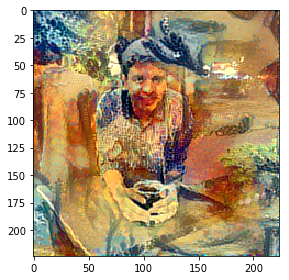

In [44]:
iterations = 10

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),fprime=evaluator.grad, maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))
    
    x1 = copy.deepcopy(x)
    x1 = x1.reshape((height, width, 3))
    # Convert back from BGR to RGB to display the image
    x1 = x1[:, :, ::-1]
    x1[:, :, 0] += 103.939
    x1[:, :, 1] += 116.779
    x1[:, :, 2] += 123.68
    x1 = np.clip(x1, 0, 255).astype('uint8')
    imshow(x1)
    img_final = Image.fromarray(x1)
    img_final.save('result2' + str(i) + '.jpg')